In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import cluster
from tqdm import tqdm

from datetime import date

In [2]:
data = pd.read_csv('../data/men_velodata.csv')
data.columns

Index(['name', 'stage', 'points_scale', 'parcours_type', 'year', 'month',
       'day', 'type', 'length', 'profile_score', 'avg_speed',
       'vertical_meters', 'won_how', 'place', 'rider', 'team', 'age', 'time'],
      dtype='object')

In [3]:
# extract data for each stage into a dictionary
stage_data = {} 
for i in tqdm(data.index):

    if data.loc[i, 'type'] not in ['standard', 'itt']:
        continue

    race = data.loc[i, 'name']
    year = data.loc[i, 'year']

    try:
        stage = int(data.loc[i, 'stage'].split('-')[1])
    except:
        continue

    if (race, year) not in stage_data:
        stage_data[(race, year)] = {}
    
    if stage not in stage_data[(race, year)]:

        stage_data[(race, year)][stage] = {
            'points_scale': data.loc[i, 'points_scale'],
            'parcours_type': data.loc[i, 'parcours_type'],
            'race_type': data.loc[i, 'type'],
            'race_length': data.loc[i, 'length'],
            'profile_score': data.loc[i, 'profile_score'],
            'avg_speed': data.loc[i, 'avg_speed'],
            'vertical_meters': data.loc[i, 'vertical_meters'],
            'winner': data.loc[i, 'rider']
        }

# convert stage data into a df
stage_df = {'name': [], 'year': [], 'stage': [], 'points_scale': [], 'parcours_type': [], 'race_type': [], 'race_length': [], 'profile_score': [], 'avg_speed': [], 'vertical_meters': [], 'winner': []}
for race, year in stage_data:
    for stage in stage_data[(race, year)]:
        stage_df['name'].append(race)
        stage_df['year'].append(year)
        stage_df['stage'].append(stage)
        for key in stage_data[(race, year)][stage]:
            stage_df[key].append(stage_data[(race, year)][stage][key])

stage_df = pd.DataFrame(stage_df)
stage_df

100%|██████████| 634880/634880 [00:18<00:00, 35094.54it/s]


,name,year,stage,points_scale,parcours_type,race_type,race_length,profile_score,avg_speed,vertical_meters,winner
0,tour-de-france,2020.0,1,GT.A.Stage,p2,standard,156.0,46.0,41.35 km/h,1597.0,KRISTOFF Alexander
1,tour-de-france,2020.0,2,GT.A.Stage,p4,standard,185.0,188.0,37.57 km/h,4066.0,ALAPHILIPPE Julian
2,tour-de-france,2020.0,3,GT.A.Stage,p2,standard,198.0,81.0,37.39 km/h,3003.0,EWAN Caleb
3,tour-de-france,2020.0,4,GT.A.Stage,p5,standard,160.5,200.0,38.86 km/h,3200.0,ROGLIČ Primož
4,tour-de-france,2020.0,5,GT.A.Stage,p1,standard,183.0,31.0,42.01 km/h,1388.0,VAN AERT Wout
...,...,...,...,...,...,...,...,...,...,...,...
3754,tour-of-the-alps,2022.0,1,2.PRO.Stage,p4,standard,160.9,227.0,38.254 km/h,3693.0,BOUCHARD Geoffrey
3755,tour-of-the-alps,2022.0,2,2.PRO.Stage,p4,standard,154.1,153.0,39.167 km/h,3228.0,BILBAO Pello
3756,tour-of-the-alps,2022.0,3,2.PRO.Stage,p5,standard,154.6,193.0,38.183 km/h,3287.0,KÄMNA Lennard
3757,tour-of-the-alps,2022.0,4,2.PRO.Stage,p5,standard,142.4,159.0,40.867 km/h,2386.0,LÓPEZ Miguel Ángel


In [4]:
import json
import sys
sys.path.append('/Users/samuelhmorton/indiv_projects/work/velo-research')
from ratings.Velo import Velo
from ratings import utils

VERBOSE = True
TIMEGAP_MULTIPLIER = None  # weight given to margin of victory
NEW_SEASON_REGRESS_WEIGHT = 0.4  # weight the degree to which rider scores converge to 1500 during off season
RAW_RESULT_NUM_PRINTED = 15  # number of finishers printed in raw data per race if VERBOSE = True
SAVE_RESULTS = False

beg_year = 2007
end_year = 2023
gender = 'men'
race_type = 'gc'

# ===== Establish data paths for the script ===== #
WEIGHTS_PATH = '../data/race_weight_data.json'
RESULTS_DATA_PATH = '../data/men_velodata.csv' if gender == 'men' else 'data/women_velodata.csv'
RACE_CLASSES_PATH = '../data/men_races_data.json' if gender == 'men' else 'data/women_races_data.json'

# results data
DATA = pd.read_csv(RESULTS_DATA_PATH)

# store race class variables here... to be converted to actual weights using WEIGHTS variable
with open(RACE_CLASSES_PATH) as f:
    RACE_CLASSES = json.load(f)
f.close()
with open(WEIGHTS_PATH) as f:
    WEIGHTS = json.load(f)
f.close()

# init elo system variable
elo = Velo(decay_alpha = 1.5, decay_beta = 1.8)

# loop through each year in the gc data
for year in range(beg_year, end_year):
    
    # prepare and isolate data for the given year
    year_data = utils.prepare_year_data(DATA, year, race_type = race_type)
    if len(year_data) == 0:
        continue

    print(f'\n====={year}=====\n')
    
    # loop through each race in the current year's data
    for race in year_data['name'].unique():

        # if race is not contained within the weight data, skip
        if race not in RACE_CLASSES[race_type][str(year)]:
            continue
        
        stages_data = utils.prepare_race_data(year_data, race)
        for stage_data in stages_data:

            # get the stage number
            stage_name = stage_data['stage'].iloc[0]

            # get race weight
            race_weight = WEIGHTS[gender][race_type][str(RACE_CLASSES[race_type][str(year)][race])]
            
            # get the race's date as date object
            stage_date = utils.get_race_date(stage_data)

            # save the elo system in a dictionary
            elo.save_system(stage_date)
            
            # simulate the race and add it to the rankings
            elo.simulate_race(race, stage_data, race_weight, TIMEGAP_MULTIPLIER)
            
            # apply changes to rider elos
            elo.apply_all_deltas(race, race_weight, stage_date)
            
            if VERBOSE:

                # print raw results for the current race
                print(f'\n==={race} - {year} - {stage_name} - (weight = {race_weight})===\n')
                print(stage_data[['place', 'rider', 'time', 'team']].iloc[0: RAW_RESULT_NUM_PRINTED, :])

                # print the elo system after this race is added
                elo.print_system(year, min_rating = 1500)

            if SAVE_RESULTS:
                elo.save_system(stage_date)
    
    # regress scores back to the mean of 1500 at the start of each season
    if year < end_year - 1:
        elo.new_season_regression(year, regression_to_mean_weight = NEW_SEASON_REGRESS_WEIGHT)

if SAVE_RESULTS:
    elo.save_system_data(f'{race_type}_{gender}')

Jonas  112.0                             Jumbo-Visma
2     3.0         LANDA Mikel  153.0                    Bahrain - Victorious
3     4.0        PORTE Richie  164.0                        INEOS Grenadiers
4     5.0         HINDLEY Jai  185.0                        BORA - hansgrohe
5     6.0     ARENSMAN Thymen  196.0                                Team DSM
6     7.0      CARUSO Damiano  200.0                    Bahrain - Victorious
7     8.0       PINOT Thibaut  217.0                          Groupama - FDJ
8     9.0        BILBAO Pello  231.0                    Bahrain - Victorious
9    10.0      CICCONE Giulio  243.0                        Trek - Segafredo
10   11.0     EVENEPOEL Remco  260.0             Quick-Step Alpha Vinyl Team
11   12.0       BARDET Romain  269.0                                Team DSM
12   13.0  POZZOVIVO Domenico  316.0  Intermarché - Wanty - Gobert Matériaux
13   14.0      URÁN Rigoberto  393.0                   EF Education-EasyPost
14   15.0          SOLE

In [5]:
# prepare stage data to plot in 2d
def prepare_stage_data(stage_df, races, years, drop_tt = True):

    races_df = pd.DataFrame()
    stage_annots = []
    for race, year in zip(races, years):
        race_df = stage_df[stage_df['name'] == race]
        race_df = race_df[race_df['year'] == year]
        
        stage_annot = list(zip(race_df['name'], race_df['year'].astype(int), race_df['stage'], race_df['winner']))


        # edit columns, numerify features, and normalize
        race_df = race_df[['parcours_type', 'race_type', 'race_length', 'vertical_meters']]
        race_df.replace(['p0', 'p1', 'p2', 'p3', 'p4', 'p5'], range(6), inplace = True)
        race_df.replace(['standard', 'itt'], [0, 1], inplace = True)

        if drop_tt:
            race_df = race_df[race_df['race_type'] != 'itt']
        
        
        races_df = pd.concat([races_df, race_df])
        stage_annots += stage_annot
    
    
    races_df = pd.DataFrame(normalize(races_df.to_numpy(), axis = 0), columns = races_df.columns)
    return races_df, stage_annots

In [6]:
# plot stage profiles in 2d
def plot_2d(race_df, stage_annots = None):

    embedder = PCA(n_components = 2)
    latent = embedder.fit_transform(race_df.to_numpy())
    latent = [[t[0] for t in latent], [t[1] for t in latent]]

    fig, ax = plt.subplots(figsize = (12, 20))
    ax.scatter(latent[0], latent[1])

    # label the plot with winners if winners are given
    if stage_annots is not None:
        for i, annot in enumerate(stage_annots):
            ax.annotate(annot, (latent[0][i], latent[1][i]))
    
    plt.show()

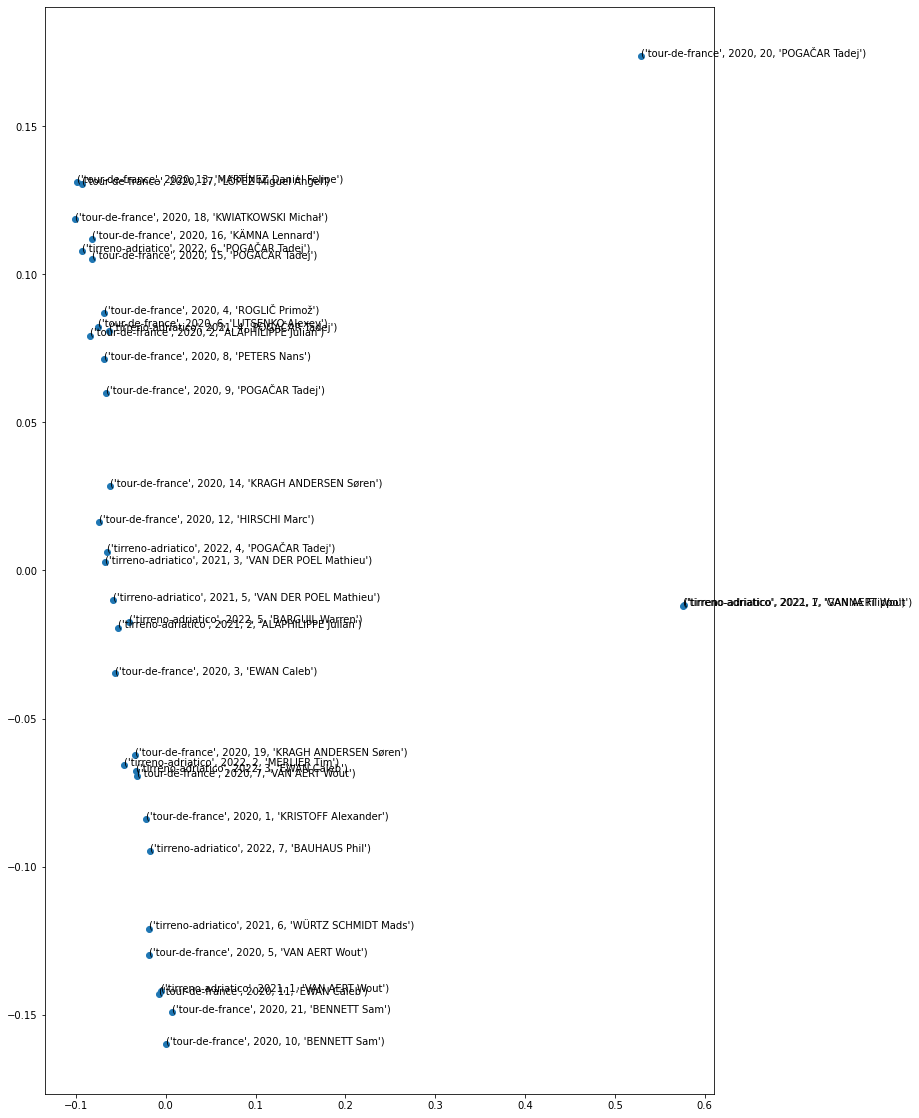

In [7]:
latent, stage_annots = prepare_stage_data(stage_df, ['tirreno-adriatico', 'tirreno-adriatico', 'tour-de-france'], [2021, 2022, 2020])
plot_2d(latent, stage_annots)

In [8]:
POINTS_SCALE_CODE = {
    '2.2/U23': 0, '2.1': 1, '2.PRO': 2, '2.WT': 3, '1.WT.B': 3, '1.WT.A': 3, 'GT.B': 4, 'GT.A': 5
}

# aggregate stats for races
def agg_race_stats(all_data, stages_df, race, year):

    race_df = stages_df[stages_df['name'] == race]
    race_df = race_df[race_df['year'] == year]

    if len(race_df.index) == 0:
        return None

    gc_data = all_data[all_data['type'] == 'gc']
    gc_data = gc_data[gc_data['name'] == race]
    gc_data = gc_data[gc_data['year'] == year]
    race_date = date(year = year, month = int(gc_data['month'].iloc[0]), day = int(gc_data['day'].iloc[0]))
    top10_ratings = []
    for name in gc_data['rider'][0: 10]:
        rating_going_in = None
        for i, t in enumerate(elo.riders[name].rating_history):
            if isinstance(t[1], str): continue
            if t[1] >= race_date:
                rating_going_in = elo.riders[name].rating_history[i - 1][0]
        if rating_going_in is None:
            rating_going_in = 1500
        top10_ratings.append(rating_going_in)

    race_data = {}

    # get race features
    pc_counts = race_df['parcours_type'].value_counts()
    race_data['is_gt'] = [0 if len(race_df.index) < 15 else 1]
    race_data['num_p0'] = [pc_counts['p0'] if 'p0' in pc_counts else 0]
    race_data['num_p1'] = [pc_counts['p1'] if 'p1' in pc_counts else 0]
    race_data['num_p2'] = [pc_counts['p2'] if 'p2' in pc_counts else 0]
    race_data['num_p3'] = [pc_counts['p3'] if 'p3' in pc_counts else 0]
    race_data['num_p4'] = [pc_counts['p4'] if 'p4' in pc_counts else 0]
    race_data['num_p5'] = [pc_counts['p5'] if 'p5' in pc_counts else 0]

    race_data['points_scale'] = [POINTS_SCALE_CODE[gc_data['points_scale'].iloc[0]]]
    
    # race_data['mean_vert'] = [np.mean(race_df['vertical_meters'])]
    # race_data['std_vert'] = [np.std(race_df['vertical_meters'])]
    # race_data['max_vert'] = [max(race_df['vertical_meters'])]
    # race_data['mean_length'] = [np.mean(race_df['race_length'])]
    # race_data['std_length'] = [np.std(race_df['race_length'])]
    # race_data['max_length'] = [max(race_df['race_length'])]

    race_data['top10_max'] = [max(top10_ratings)]
    race_data['top10_min'] = [min(top10_ratings)]
    race_data['top10_mean'] = [np.mean(top10_ratings)]

    itt_df = race_df[race_df['race_type'] == 'itt']
    race_data['num_itt'] = [len(itt_df.index)]
    race_data['itt_kms'] = [sum(itt_df['race_length'])]

    return pd.DataFrame(data = race_data, index = [0])

def combine_data(data_lst, reduce_dims = True, normalize_data = True):
    data = pd.concat(data_lst)

    if normalize_data:
        data = normalize(data.to_numpy(), axis = 0)

    if reduce_dims:
        embedder = PCA(n_components = 2)
        data = pd.DataFrame(embedder.fit_transform(data))
    
    return data

In [9]:
races = ['adriatica-ionica-race', 'arctic-race-of-norway', 'benelux-tour',
       'boucles-de-la-mayenne', 'czech-cycling-tour', 'dauphine',
       'deutschland-tour', 'etoile-de-besseges',
       'itzulia-basque-country', 'la-route-d-occitanie',
       'okolo-slovenska', 'paris-nice', 'ruta-del-sol',
       'settimana-ciclistica-italiana',
       'settimana-internazionale-coppi-e-bartali', 'sibiu-cycling-tour',
       'tirreno-adriatico', 'tour-cycliste-international-la-provence',
       'tour-de-hongrie', 'tour-de-l-ain',
       'tour-de-luxembourg', 'tour-de-pologne', 'tour-de-romandie',
       'tour-de-suisse', 'tour-de-wallonie',
       'tour-des-alpes-maritimes-et-du-var', 'tour-du-limousin',
       'tour-du-poitou-charentes-et-de-la-vienne', 'tour-of-belgium',
       'tour-of-britain', 'tour-of-denmark', 'tour-of-norway',
       'tour-of-rwanda', 'tour-of-slovenia', 'tour-of-the-alps',
       'tour-of-turkey', 'uae-tour', 'volta-a-catalunya',
       'volta-a-portugal', 'volta-ao-algarve', 'vuelta-a-burgos',
       'vuelta-a-la-comunidad-valenciana',
       'vuelta-asturias', 'tour-de-france', 'giro-d-italia', 'vuelta-a-espana']
years = range(2010, 2023)
to_plot = [(r, y) for r in races for y in years]
agg_stats = [
    agg_race_stats(data, stage_df, r, y) for r, y in to_plot
]
agg_stats = [v for v in agg_stats if v is not None]
#latent = combine_data(agg_stats)
#plot_2d(latent, [f'{r}-{y}' for r, y in to_plot])

In [10]:
df = combine_data(agg_stats, reduce_dims = False, normalize_data = False)
df0 = df.drop(columns = ['top10_max', 'top10_min', 'top10_mean'])
df0 = pd.DataFrame(normalize(df0, axis = 0), columns = df0.columns)
df0['top10_mean'] = list(df['top10_mean'])
#df0.insert(0, 'top10_mean', list(df['top10_mean']))
df0.to_csv('../data/sample_gc_level_prediction_data.csv', index = False)